In [ ]:
import os
import dask.dataframe as dd
import numpy as np
import pandas as pd
from itertools import combinations
from math import sqrt, log
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from concurrent.futures import ThreadPoolExecutor
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint

# Function

In [ ]:
def download_data(stock1, stock2, start_date):
    df1 = yf.download(stock1, start = start_date)
    df2 = yf.download(stock2, start = start_date)
    common_dates = df1.index.intersection(df2.index)
    df1 = df1.loc[common_dates]
    df2 = df2.loc[common_dates]

    if not check_coint(df1, df2):
        print("無共整合")
    
    return pd.DataFrame(df1), pd.DataFrame(df2)

def check_coint(df1, df2):
    def adf_test(series):
        result = adfuller(series)
        p_value = result[1]
        print(f"ADF Test p-value: {p_value}")
        return p_value < 0.05

    price_ratio = df1['Close'] / df2['Close']
    is_stationary = adf_test(price_ratio)

    score, p_value, _ = coint(df1['Close'], df2['Close'])
    is_coint = p_value < 0.05

    if is_stationary and is_coint:
        return True
    else:
        return False

def ou_params(spread):
    n = len(spread)
    delta_t = 1
    spread_diff = np.diff(spread)
    spread_lag = spread[:-1]

    def negative_log_likelihood(params):
        mu, theta, sigma = params
        residual = spread_diff - theta * (mu - spread_lag) * delta_t
        variance = sigma ** 2 * (1 - np.exp(-2 * theta * delta_t)) / (2 * theta)
        log_likelihood = (
            -0.5 * n * np.log(2 * np.pi)
            - 0.5 * n * np.log(variance)
            - (residual ** 2).sum() / (2 * variance)
        )
        return -log_likelihood

    initial_params = [np.mean(spread), 0.1, np.std(spread)]
    bounds = [(None, None), (1e-5, None), (1e-5, None)]

    result = minimize(negative_log_likelihood, initial_params, bounds=bounds)

    if not result.success:
        return np.nan, np.nan, np.nan

    mu, theta, sigma = result.x

    # 這裡是因為做出來theta有負數，如果是共整合還會有負數嗎？
    min_theta = max(1e-5, np.std(spread) / 100)
    theta = max(theta, min_theta)

    return mu, theta, sigma

def calculate_spread_and_zscore(df1, df2):
    hedge_ratio = sm.OLS(df1['Close'], df2['Close']).fit().params.iloc[0]
    spread = df1['Close'] - hedge_ratio * df2['Close']
    return spread

def generate_signal(df1, df2, holding_period_limit, window = 50):
    signal_df = pd.DataFrame(columns = ['spread', 'theta', 'mu', 'sigma'], index = df1.index)
    signal_df['signal'] = 0
    signal_df['spread'] = calculate_spread_and_zscore(df1, df2)
    holiding_counter = 0
    stop_loss_zscore = 3

    for i in range(len(signal_df)):
        theta, mu, sigma = ou_params(signal_df['spread'].iloc[i - window: i])
        signal_df.loc[signal_df.index[i], 'theta'] = theta
        signal_df.loc[signal_df.index[i], 'mu'] = mu
        signal_df.loc[signal_df.index[i], 'sigma'] = sigma

        if signal_df['theta'].iloc[i] > 0:
            sqrt_value = np.sqrt(2 / theta)
            signal_df.loc[signal_df.index[i], 'a'] = mu + sigma * sqrt_value
            signal_df.loc[signal_df.index[i], 'b'] = mu - sigma * sqrt_value
        else:
            signal_df.loc[signal_df.index[i], 'a'] = np.nan
            signal_df.loc[signal_df.index[i], 'b'] = np.nan

        # long: long stock1, short stock2 ; short: short stock1, long stock2
        long = signal_df['spread'].iloc[i] < signal_df['b'].iloc[i]
        short = signal_df['spread'].iloc[i] > signal_df['a'].iloc[i]

        zscore = (signal_df['spread'].iloc[i] - mu) / sigma
        if abs(zscore) > stop_loss_zscore:
            signal_df.loc[signal_df.index[i], 'signal'] = 0

        elif long:
            signal_df.loc[signal_df.index[i], 'signal'] = 1
        elif short:
            signal_df.loc[signal_df.index[i], 'signal'] = -1
        
        if signal_df['signal'].iloc[i] != 0:
            holiding_counter += 1
        else:
            holiding_counter = 0

        if holiding_counter > holding_period_limit:
            signal_df.loc[signal_df.index[i], 'signal'] = 0

    return signal_df

In [129]:
def calculate_log_return(current_price1, current_price2, previous_price1, previous_price2):
    ratio_now = current_price1 / current_price2
    ratio_prev = previous_price1 / previous_price2
    log_return = np.log(ratio_now / ratio_prev)
    return log_return

def cumulate_return(ret_df):
    ret_df['cum_ret'] = (1 + ret_df['log_ret']).cumprod() - 1
    return ret_df

def generate_ret(signal_df, df1, df2):
    ret_df = pd.DataFrame(index = signal_df.index)
    ret_df['position'] = signal_df['signal'].shift(1)
    ret_df['log_ret'] = 0

    for i in range(1, len(ret_df) - 1):
        position = ret_df['position'].iloc[i]

        if position != 0:
            t = i + 1
            previous_price1 = df1['Open'].iloc[i]
            previous_price2 = df2['Open'].iloc[i]
            current_price1 = df1['Open'].iloc[i + 1]
            current_price2 = df2['Open'].iloc[i + 1]

            if position == 1:  # Long stock2, Short stock1
                log_ret = calculate_log_return(current_price2, current_price1, previous_price2, previous_price1)
            elif position == -1:  # Short stock2, Long stock1
                log_ret = calculate_log_return(current_price1, current_price2, previous_price1, previous_price2)

            ret_df.loc[ret_df.index[i], 'log_ret'] = log_ret

        ret_df = cumulate_return(ret_df)
    return ret_df


In [106]:
start_date = "2020-01-01"
holding_period_limit = 50
df1, df2 = download_data("0050.TW", "^TWII", start_date = start_date)
signal_df = generate_signal(df1, df2)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADF Test p-value: 0.5460167879067496
無共整合


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_23375/1641035107.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0020521373898812656' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret_df.loc[ret_df.index[i], 'log_ret'] = log_ret


<Axes: xlabel='Date'>

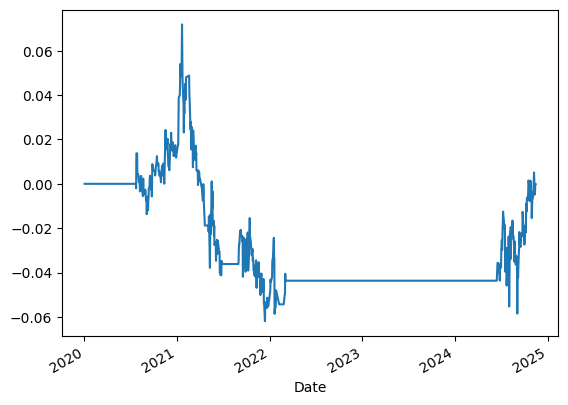

In [133]:
ret_df = generate_ret(signal_df, df1, df2)
ret_df['cum_ret'].plot()

In [147]:
signal_df

,spread,theta,mu,sigma,signal,a,b
Date,,,,,,,
2020-01-02,1.884429,NaN,NaN,NaN,0,NaN,NaN
2020-01-03,1.805689,NaN,NaN,NaN,0,NaN,NaN
2020-01-06,1.798767,NaN,NaN,NaN,0,NaN,NaN
2020-01-07,2.076817,NaN,NaN,NaN,0,NaN,NaN
2020-01-08,2.127161,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...
2024-11-08,12.589897,11.369183,0.04143,0.874738,-1,0.408314,-0.325453
2024-11-11,12.881822,11.911065,0.041012,0.872432,-1,0.398508,-0.316484
2024-11-12,12.117775,12.210337,0.042918,0.869366,-1,0.394765,-0.308929


In [134]:
ret_df.to_csv('/Users/xinc./Documents/GitHub/Quant/TMBA/Pairs/test.csv', index = False)